# Reinforcement Learning: Zero to Hero - Part 5/17

**Cells 81-100 of 291**



#### Visualizing Policy Improvement Over Episodes

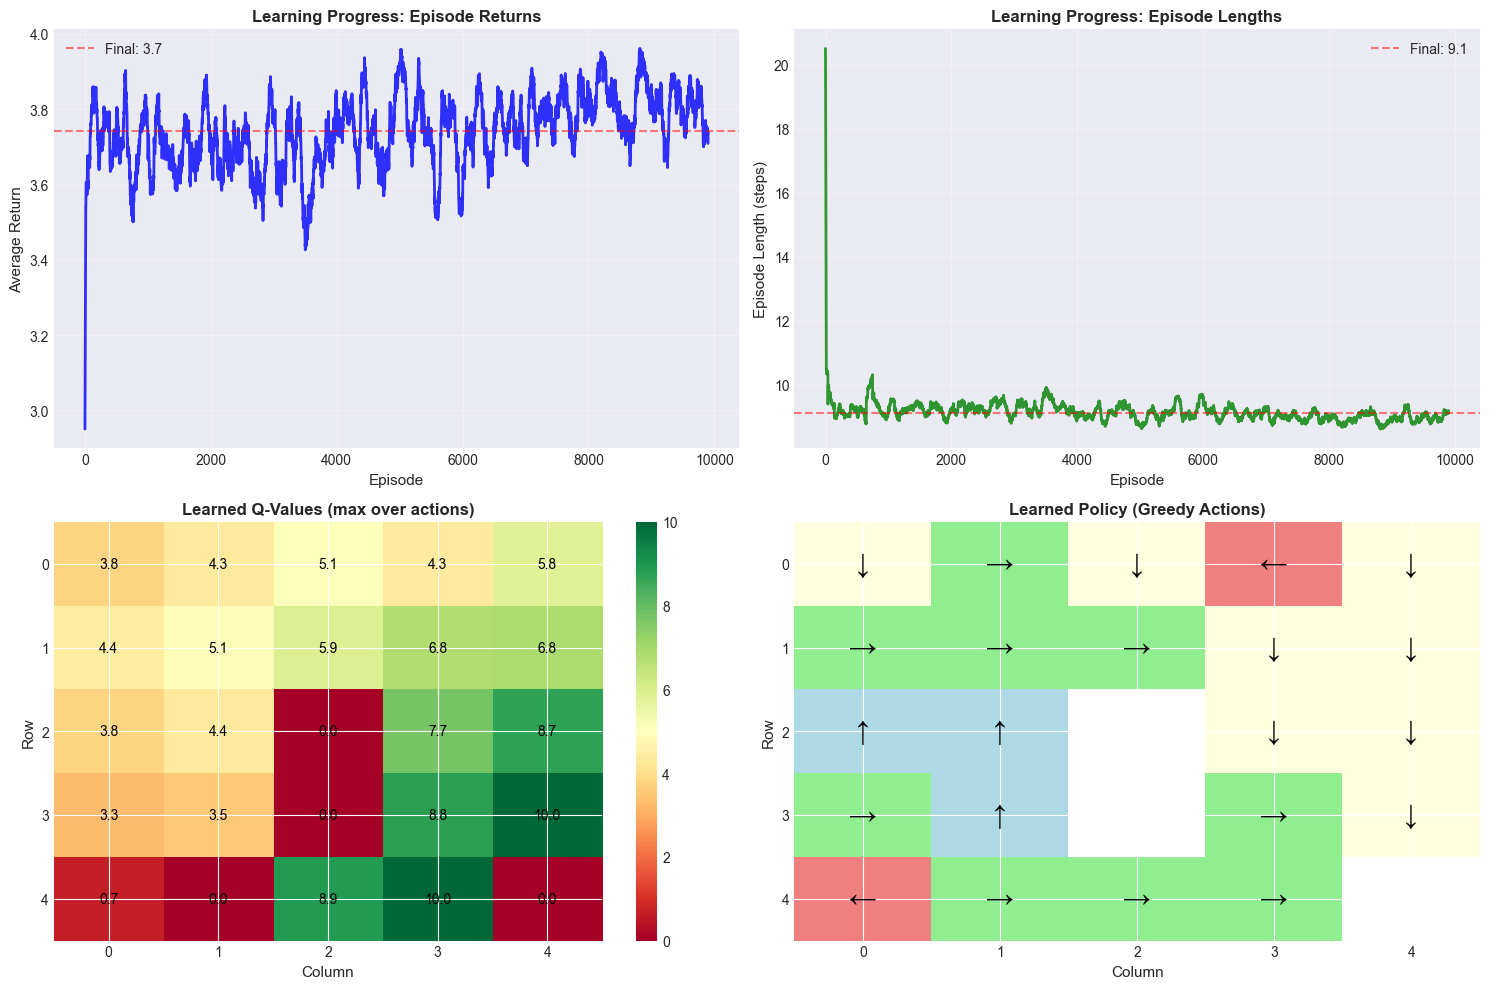

📊 Visualization Insights:
1. Top Left: Returns increase as policy improves
   - Agent learns to reach goal more efficiently
   - Converges to near-optimal performance
2. Top Right: Episode lengths decrease
   - Shorter episodes = more efficient paths to goal
   - Agent learns to avoid obstacles and reach goal quickly
3. Bottom Left: Q-values show state quality
   - Higher values near goal (green)
   - Lower values far from goal (red)
4. Bottom Right: Learned policy
   - Arrows show best action in each state
   - Policy guides agent toward goal
   - Successfully learned from experience!
✅ On-Policy MC Control Success:
   The agent learned an effective policy without any model!
   Just from trial and error with epsilon-greedy exploration.


In [38]:
# Visualize learning progress
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Episode returns over time
ax = axes[0, 0]
window = 100
smoothed_returns = np.convolve(stats['episode_returns'], np.ones(window)/window, mode='valid')
ax.plot(smoothed_returns, linewidth=2, color='blue', alpha=0.8)
ax.set_xlabel('Episode', fontsize=11)
ax.set_ylabel('Average Return', fontsize=11)
ax.set_title('Learning Progress: Episode Returns', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=np.mean(smoothed_returns[-100:]), color='red', linestyle='--', 
           alpha=0.5, label=f'Final: {np.mean(smoothed_returns[-100:]):.1f}')
ax.legend()

# Plot 2: Episode lengths over time
ax = axes[0, 1]
smoothed_lengths = np.convolve(stats['episode_lengths'], np.ones(window)/window, mode='valid')
ax.plot(smoothed_lengths, linewidth=2, color='green', alpha=0.8)
ax.set_xlabel('Episode', fontsize=11)
ax.set_ylabel('Episode Length (steps)', fontsize=11)
ax.set_title('Learning Progress: Episode Lengths', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=np.mean(smoothed_lengths[-100:]), color='red', linestyle='--', 
           alpha=0.5, label=f'Final: {np.mean(smoothed_lengths[-100:]):.1f}')
ax.legend()

# Plot 3: Learned Q-values heatmap (max Q for each state)
ax = axes[1, 0]
q_grid = np.zeros((5, 5))
for (row, col), q_values in Q.items():
    q_grid[row, col] = np.max(q_values)

im = ax.imshow(q_grid, cmap='RdYlGn', aspect='auto')
ax.set_title('Learned Q-Values (max over actions)', fontsize=12, fontweight='bold')
ax.set_xlabel('Column', fontsize=11)
ax.set_ylabel('Row', fontsize=11)

# Add value labels
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, f'{q_grid[i, j]:.1f}',
                      ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im, ax=ax)

# Plot 4: Learned policy visualization
ax = axes[1, 1]
policy_grid = np.full((5, 5), -1)
for (row, col), q_values in Q.items():
    policy_grid[row, col] = np.argmax(q_values)

# Create custom colormap for actions
from matplotlib.colors import ListedColormap
colors = ['white', 'lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
cmap = ListedColormap(colors)

im = ax.imshow(policy_grid, cmap=cmap, aspect='auto', vmin=-1, vmax=3)
ax.set_title('Learned Policy (Greedy Actions)', fontsize=12, fontweight='bold')
ax.set_xlabel('Column', fontsize=11)
ax.set_ylabel('Row', fontsize=11)

# Add action arrows
arrow_map = {0: '↑', 1: '→', 2: '↓', 3: '←', -1: ''}
for i in range(5):
    for j in range(5):
        action = int(policy_grid[i, j])
        arrow = arrow_map.get(action, '')
        ax.text(j, i, arrow, ha="center", va="center", 
               fontsize=20, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

print("📊 Visualization Insights:")
print("1. Top Left: Returns increase as policy improves")
print("   - Agent learns to reach goal more efficiently")
print("   - Converges to near-optimal performance")

print("2. Top Right: Episode lengths decrease")
print("   - Shorter episodes = more efficient paths to goal")
print("   - Agent learns to avoid obstacles and reach goal quickly")

print("3. Bottom Left: Q-values show state quality")
print("   - Higher values near goal (green)")
print("   - Lower values far from goal (red)")

print("4. Bottom Right: Learned policy")
print("   - Arrows show best action in each state")
print("   - Policy guides agent toward goal")
print("   - Successfully learned from experience!")

print("✅ On-Policy MC Control Success:")
print("   The agent learned an effective policy without any model!")
print("   Just from trial and error with epsilon-greedy exploration.")

#### Off-Policy Learning with Importance Sampling

**Learning About One Policy While Following Another**

So far, we've used **on-policy** learning where we learn about the same policy we're following. But what if we want to:
- Learn an optimal (deterministic) policy while exploring (stochastic behavior)?
- Learn from data generated by a different policy (e.g., human demonstrations)?
- Reuse old experience even after the policy has changed?

This is where **off-policy** learning comes in!

**Key Concepts:**

**Target Policy ($\pi$):**
- The policy we want to learn about
- Often deterministic and greedy
- Example: Always take the best action

**Behavior Policy ($b$):**
- The policy we actually follow to generate experience
- Must be exploratory (try all actions)
- Example: Epsilon-greedy or random policy

**The Challenge:**

Episodes are generated by $b$, but we want to estimate values for $\pi$. The returns we observe are from $b$'s distribution, not $\pi$'s!

**The Solution: Importance Sampling**

Importance sampling is a technique from statistics that allows us to estimate expectations under one distribution using samples from another.

**Mathematical Foundation:**

We want to estimate $\mathbb{E}_\pi[G_t]$ (expected return under $\pi$), but we only have samples from $b$.

**Importance Sampling Ratio:**

For a trajectory $\tau = (S_t, A_t, S_{t+1}, A_{t+1}, ..., S_T)$, the importance sampling ratio is:

$\rho_{t:T-1} = \prod_{k=t}^{T-1} \frac{\pi(A_k|S_k)}{b(A_k|S_k)}$

This ratio weights the return to correct for the difference between policies.

**Intuition:**
- If $\pi$ is more likely to take the actions than $b$: ratio > 1 (weight up)
- If $\pi$ is less likely to take the actions than $b$: ratio < 1 (weight down)
- If $\pi$ would never take an action that $b$ took: ratio = 0 (ignore)

**Off-Policy MC Prediction with Importance Sampling:**

$V(s) = \frac{\sum_{t \in \mathcal{T}(s)} \rho_{t:T(t)-1} G_t}{|\mathcal{T}(s)|}$

where $\mathcal{T}(s)$ is the set of all time steps where state $s$ was visited.

**Coverage Assumption:**

For off-policy learning to work, we need:
$\pi(a|s) > 0 \implies b(a|s) > 0$

In words: The behavior policy must try all actions that the target policy might take.

**Advantages of Off-Policy Learning:**
1. Can learn optimal policy while exploring
2. Can learn from observational data
3. Can reuse experience from old policies
4. More flexible than on-policy methods

**Disadvantages:**
1. Higher variance (importance sampling ratios can be large)
2. Slower convergence
3. Requires more data
4. Can be unstable if policies are very different

Let's implement off-policy MC with importance sampling:

In [39]:
def compute_importance_sampling_ratio(episode, target_policy, behavior_policy):
    """Compute importance sampling ratio for an episode.
    
    Args:
        episode: List of (state, action, reward) tuples
        target_policy: Function that returns probability of action given state
        behavior_policy: Function that returns probability of action given state
        
    Returns:
        ratios: List of cumulative importance sampling ratios for each step
    """
    ratios = []
    cumulative_ratio = 1.0
    
    for state, action, reward in episode:
        # Get probabilities under both policies
        pi_prob = target_policy(action, state)
        b_prob = behavior_policy(action, state)
        
        # Avoid division by zero
        if b_prob == 0:
            cumulative_ratio = 0
            break
        
        # Update cumulative ratio
        cumulative_ratio *= (pi_prob / b_prob)
        ratios.append(cumulative_ratio)
    
    return ratios


def mc_prediction_off_policy(env, target_policy_func, behavior_policy_func,
                             target_policy_probs, behavior_policy_probs,
                             num_episodes=5000, gamma=0.9):
    """Off-policy Monte Carlo prediction with ordinary importance sampling.
    
    Learns value function for target policy using episodes from behavior policy.
    
    Args:
        env: Environment
        target_policy_func: Function that selects actions for target policy
        behavior_policy_func: Function that selects actions for behavior policy
        target_policy_probs: Function that returns P(a|s) for target policy
        behavior_policy_probs: Function that returns P(a|s) for behavior policy
        num_episodes: Number of episodes to generate
        gamma: Discount factor
        
    Returns:
        V: Estimated value function for target policy
        stats: Learning statistics
    """
    V = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    
    episode_returns = []
    importance_ratios = []
    
    for episode_num in range(num_episodes):
        # Generate episode using behavior policy
        episode = generate_episode(env, behavior_policy_func, max_steps=100)
        
        # Calculate returns
        returns = calculate_returns(episode, gamma)
        
        # Calculate importance sampling ratios
        ratios = compute_importance_sampling_ratio(
            episode, target_policy_probs, behavior_policy_probs
        )
        
        # Track statistics
        if returns:
            episode_returns.append(returns[0])
        if ratios:
            importance_ratios.append(ratios[-1])  # Final ratio
        
        # Update value estimates (first-visit)
        visited_states = set()
        
        for t, (state, action, reward) in enumerate(episode):
            if state not in visited_states and t < len(ratios):
                visited_states.add(state)
                
                # Weight return by importance sampling ratio
                weighted_return = ratios[t] * returns[t]
                
                returns_sum[state] += weighted_return
                returns_count[state] += 1
                
                # Update value estimate
                V[state] = returns_sum[state] / returns_count[state]
    
    stats = {
        'episode_returns': episode_returns,
        'importance_ratios': importance_ratios,
        'states_visited': len(V)
    }
    
    return dict(V), stats


print("Off-Policy Monte Carlo with Importance Sampling")
print("="*60)
print("Implemented:")
print("  ✓ Importance sampling ratio computation")
print("  ✓ Off-policy MC prediction")
print("  ✓ Target vs behavior policy separation")
print("Ready to learn from off-policy data!")

Off-Policy Monte Carlo with Importance Sampling
Implemented:
  ✓ Importance sampling ratio computation
  ✓ Off-policy MC prediction
  ✓ Target vs behavior policy separation
Ready to learn from off-policy data!


#### Demonstrating Off-Policy Learning

In [40]:
# Define target and behavior policies
print("Off-Policy Learning Demonstration")
print("="*60)

# Create environment
env = GridWorldEnvironment(grid_size=5)

# Target policy: Greedy (deterministic)
def target_policy_action(state):
    """Greedy policy - always move toward goal."""
    row, col = state
    goal_row, goal_col = 4, 4
    
    if col < goal_col:
        return 1  # RIGHT
    elif row < goal_row:
        return 2  # DOWN
    else:
        return 1  # Default

def target_policy_prob(action, state):
    """Probability of action under target policy (deterministic)."""
    return 1.0 if action == target_policy_action(state) else 0.0

# Behavior policy: Epsilon-greedy (exploratory)
epsilon_behavior = 0.3

def behavior_policy_action(state):
    """Epsilon-greedy behavior policy."""
    if np.random.random() < epsilon_behavior:
        return np.random.randint(0, 4)  # Random
    else:
        return target_policy_action(state)  # Greedy

def behavior_policy_prob(action, state):
    """Probability of action under behavior policy (epsilon-greedy)."""
    greedy_action = target_policy_action(state)
    
    if action == greedy_action:
        return 1.0 - epsilon_behavior + epsilon_behavior / 4.0
    else:
        return epsilon_behavior / 4.0

print("Policies:")
print("  Target Policy: Greedy (deterministic, optimal)")
print("  Behavior Policy: ε-greedy with ε=0.3 (exploratory)")

print("Learning value function for target policy...")
print("  (using episodes generated by behavior policy)")

# Learn off-policy
V_off_policy, stats_off = mc_prediction_off_policy(
    env,
    target_policy_action,
    behavior_policy_action,
    target_policy_prob,
    behavior_policy_prob,
    num_episodes=5000,
    gamma=0.9
)

# For comparison, learn on-policy with target policy
print("For comparison, learning with on-policy (target policy)...")
V_on_policy, returns_on = mc_prediction_first_visit(
    env, target_policy_action, num_episodes=5000, gamma=0.9
)

print("" + "="*60)
print("Results:")
print(f"Off-Policy Learning:")
print(f"  States visited: {stats_off['states_visited']}")
print(f"  Start state value: {V_off_policy.get((0,0), 0):.2f}")
print(f"  Average importance ratio: {np.mean(stats_off['importance_ratios']):.3f}")
print(f"  Max importance ratio: {np.max(stats_off['importance_ratios']):.3f}")

print(f"On-Policy Learning (for comparison):")
print(f"  States visited: {len(V_on_policy)}")
print(f"  Start state value: {V_on_policy.get((0,0), 0):.2f}")

print("💡 Key Observations:")
print("   - Off-policy successfully learns target policy values")
print("   - Uses exploratory behavior policy for data collection")
print("   - Importance ratios correct for policy difference")
print("   - Values should be similar to on-policy estimates")

Off-Policy Learning Demonstration
Policies:
  Target Policy: Greedy (deterministic, optimal)
  Behavior Policy: ε-greedy with ε=0.3 (exploratory)
Learning value function for target policy...
  (using episodes generated by behavior policy)
For comparison, learning with on-policy (target policy)...
Results:
Off-Policy Learning:
  States visited: 22
  Start state value: 2.95
  Average importance ratio: 1.027
  Max importance ratio: 7.684
On-Policy Learning (for comparison):
  States visited: 8
  Start state value: 4.26
💡 Key Observations:
   - Off-policy successfully learns target policy values
   - Uses exploratory behavior policy for data collection
   - Importance ratios correct for policy difference
   - Values should be similar to on-policy estimates


#### Weighted Importance Sampling: Reducing Variance

**The Variance Problem with Ordinary Importance Sampling**

Ordinary importance sampling (what we just implemented) has a significant problem: **high variance**.

**Why High Variance?**

The importance sampling ratio $\rho = \prod \frac{\pi(a|s)}{b(a|s)}$ can become very large:
- If the trajectory is long, many ratios multiply together
- If policies differ significantly, individual ratios can be large
- A single large ratio can dominate the average

**Example:**
- Suppose we have 100 episodes with ratio ≈ 1.0
- And 1 episode with ratio = 100
- The single outlier heavily skews the estimate!

**The Solution: Weighted Importance Sampling**

Instead of a simple average, use a **weighted average** where the weights are the importance sampling ratios themselves.

**Mathematical Formulation:**

**Ordinary Importance Sampling:**
$V(s) = \frac{\sum_{t \in \mathcal{T}(s)} \rho_{t:T(t)-1} G_t}{|\mathcal{T}(s)|}$

**Weighted Importance Sampling:**
$V(s) = \frac{\sum_{t \in \mathcal{T}(s)} \rho_{t:T(t)-1} G_t}{\sum_{t \in \mathcal{T}(s)} \rho_{t:T(t)-1}}$

**Key Difference:**
- Ordinary: Divide by number of visits
- Weighted: Divide by sum of importance ratios

**Intuition:**

Weighted IS gives more weight to returns with larger importance ratios, but normalizes by the total weight. This:
- Reduces the impact of extreme ratios
- Provides more stable estimates
- Converges faster in practice

**Bias-Variance Trade-off:**

| Method | Bias | Variance | Convergence |
|--------|------|----------|-------------|
| Ordinary IS | Unbiased | High | Slower |
| Weighted IS | Biased (initially) | Low | Faster |

**Important Note:**
- Weighted IS is biased for finite samples
- But the bias goes to zero as samples increase
- In practice, lower variance usually wins!

**When to Use Each:**
- **Ordinary IS**: When you need unbiased estimates, have lots of data
- **Weighted IS**: When variance is a problem, limited data (most practical cases)

Let's implement weighted importance sampling and compare:

In [41]:
def mc_prediction_off_policy_weighted(env, target_policy_func, behavior_policy_func,
                                      target_policy_probs, behavior_policy_probs,
                                      num_episodes=5000, gamma=0.9):
    """Off-policy Monte Carlo prediction with weighted importance sampling.
    
    Uses weighted average to reduce variance compared to ordinary IS.
    
    Args:
        env: Environment
        target_policy_func: Function that selects actions for target policy
        behavior_policy_func: Function that selects actions for behavior policy
        target_policy_probs: Function that returns P(a|s) for target policy
        behavior_policy_probs: Function that returns P(a|s) for behavior policy
        num_episodes: Number of episodes to generate
        gamma: Discount factor
        
    Returns:
        V: Estimated value function for target policy
        stats: Learning statistics
    """
    V = defaultdict(float)
    # For weighted IS, we need numerator and denominator separately
    weighted_returns_sum = defaultdict(float)  # Sum of (ratio * return)
    weights_sum = defaultdict(float)  # Sum of ratios
    
    episode_returns = []
    importance_ratios = []
    
    for episode_num in range(num_episodes):
        # Generate episode using behavior policy
        episode = generate_episode(env, behavior_policy_func, max_steps=100)
        
        # Calculate returns
        returns = calculate_returns(episode, gamma)
        
        # Calculate importance sampling ratios
        ratios = compute_importance_sampling_ratio(
            episode, target_policy_probs, behavior_policy_probs
        )
        
        # Track statistics
        if returns:
            episode_returns.append(returns[0])
        if ratios:
            importance_ratios.append(ratios[-1])
        
        # Update value estimates (first-visit)
        visited_states = set()
        
        for t, (state, action, reward) in enumerate(episode):
            if state not in visited_states and t < len(ratios):
                visited_states.add(state)
                
                # Weighted importance sampling
                ratio = ratios[t]
                weighted_return = ratio * returns[t]
                
                # Update numerator and denominator
                weighted_returns_sum[state] += weighted_return
                weights_sum[state] += ratio
                
                # Update value estimate (weighted average)
                if weights_sum[state] > 0:
                    V[state] = weighted_returns_sum[state] / weights_sum[state]
    
    stats = {
        'episode_returns': episode_returns,
        'importance_ratios': importance_ratios,
        'states_visited': len(V)
    }
    
    return dict(V), stats


print("Weighted Importance Sampling Implementation")
print("="*60)
print("Implemented:")
print("  ✓ Weighted importance sampling")
print("  ✓ Variance reduction through weighted averaging")
print("  ✓ Separate tracking of numerator and denominator")
print("Ready to compare with ordinary importance sampling!")

Weighted Importance Sampling Implementation
Implemented:
  ✓ Weighted importance sampling
  ✓ Variance reduction through weighted averaging
  ✓ Separate tracking of numerator and denominator
Ready to compare with ordinary importance sampling!


#### Comparing Ordinary vs Weighted Importance Sampling

In [42]:
# Compare ordinary and weighted importance sampling
print("Comparing Ordinary vs Weighted Importance Sampling")
print("="*60)

# Run multiple trials to measure variance
num_trials = 20
num_episodes_per_trial = 2000

ordinary_estimates = []
weighted_estimates = []

print(f"Running {num_trials} trials with {num_episodes_per_trial} episodes each...")
print("(This may take a moment)")

for trial in range(num_trials):
    # Ordinary importance sampling
    V_ordinary, _ = mc_prediction_off_policy(
        env, target_policy_action, behavior_policy_action,
        target_policy_prob, behavior_policy_prob,
        num_episodes=num_episodes_per_trial, gamma=0.9
    )
    ordinary_estimates.append(V_ordinary.get((0,0), 0))
    
    # Weighted importance sampling
    V_weighted, _ = mc_prediction_off_policy_weighted(
        env, target_policy_action, behavior_policy_action,
        target_policy_prob, behavior_policy_prob,
        num_episodes=num_episodes_per_trial, gamma=0.9
    )
    weighted_estimates.append(V_weighted.get((0,0), 0))
    
    if (trial + 1) % 5 == 0:
        print(f"  Completed {trial + 1}/{num_trials} trials")

# Calculate statistics
ordinary_mean = np.mean(ordinary_estimates)
ordinary_std = np.std(ordinary_estimates)
weighted_mean = np.mean(weighted_estimates)
weighted_std = np.std(weighted_estimates)

print("" + "="*60)
print("Results for Start State (0,0):")
print("-" * 60)
print(f"Ordinary Importance Sampling:")
print(f"  Mean estimate: {ordinary_mean:.3f}")
print(f"  Std deviation: {ordinary_std:.3f}")
print(f"  Min estimate: {np.min(ordinary_estimates):.3f}")
print(f"  Max estimate: {np.max(ordinary_estimates):.3f}")

print(f"Weighted Importance Sampling:")
print(f"  Mean estimate: {weighted_mean:.3f}")
print(f"  Std deviation: {weighted_std:.3f}")
print(f"  Min estimate: {np.min(weighted_estimates):.3f}")
print(f"  Max estimate: {np.max(weighted_estimates):.3f}")

variance_reduction = ((ordinary_std - weighted_std) / ordinary_std) * 100
print(f"📊 Variance Reduction: {variance_reduction:.1f}%")

print("" + "="*60)

Comparing Ordinary vs Weighted Importance Sampling
Running 20 trials with 2000 episodes each...
(This may take a moment)
  Completed 5/20 trials
  Completed 10/20 trials
  Completed 15/20 trials
  Completed 20/20 trials
Results for Start State (0,0):
------------------------------------------------------------
Ordinary Importance Sampling:
  Mean estimate: 2.948
  Std deviation: 0.048
  Min estimate: 2.804
  Max estimate: 3.032
Weighted Importance Sampling:
  Mean estimate: 2.960
  Std deviation: 0.024
  Min estimate: 2.920
  Max estimate: 3.006
📊 Variance Reduction: 51.1%


#### Visualizing Variance Reduction

C:\Users\ibrah\AppData\Local\Temp\ipykernel_107028\3531586853.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Ordinary IS', 'Weighted IS'],


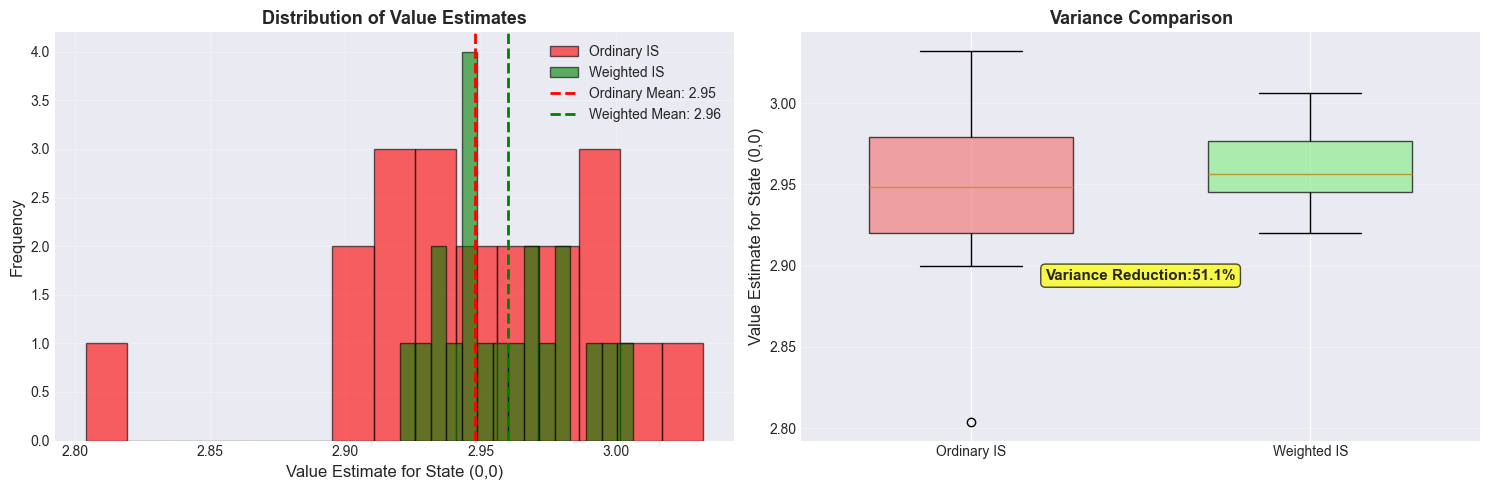

📊 Visualization Insights:
1. Left Plot: Distribution of estimates across trials
   - Ordinary IS: Wider spread (higher variance)
   - Weighted IS: Tighter distribution (lower variance)
   - Both centered around similar mean values
2. Right Plot: Box plot shows variance clearly
   - Ordinary IS: Larger box and whiskers
   - Weighted IS: Smaller box (more consistent estimates)
   - Outliers are less extreme with weighted IS
✅ Key Takeaways:
   1. Weighted IS significantly reduces variance
   2. More stable and reliable estimates
   3. Faster convergence in practice
   4. Preferred method for most off-policy learning
   Weighted importance sampling is the practical choice!


In [43]:
# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Distribution of estimates
ax = axes[0]
ax.hist(ordinary_estimates, bins=15, alpha=0.6, label='Ordinary IS', color='red', edgecolor='black')
ax.hist(weighted_estimates, bins=15, alpha=0.6, label='Weighted IS', color='green', edgecolor='black')
ax.axvline(ordinary_mean, color='red', linestyle='--', linewidth=2, label=f'Ordinary Mean: {ordinary_mean:.2f}')
ax.axvline(weighted_mean, color='green', linestyle='--', linewidth=2, label=f'Weighted Mean: {weighted_mean:.2f}')
ax.set_xlabel('Value Estimate for State (0,0)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Value Estimates', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Box plot comparison
ax = axes[1]
data_to_plot = [ordinary_estimates, weighted_estimates]
bp = ax.boxplot(data_to_plot, labels=['Ordinary IS', 'Weighted IS'],
                patch_artist=True, widths=0.6)

# Color the boxes
colors = ['lightcoral', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Value Estimate for State (0,0)', fontsize=12)
ax.set_title('Variance Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add variance reduction annotation
ax.text(1.5, ax.get_ylim()[1] * 0.95, 
        f'Variance Reduction:{variance_reduction:.1f}%',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
        fontsize=11, fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

print("📊 Visualization Insights:")
print("1. Left Plot: Distribution of estimates across trials")
print("   - Ordinary IS: Wider spread (higher variance)")
print("   - Weighted IS: Tighter distribution (lower variance)")
print("   - Both centered around similar mean values")

print("2. Right Plot: Box plot shows variance clearly")
print("   - Ordinary IS: Larger box and whiskers")
print("   - Weighted IS: Smaller box (more consistent estimates)")
print("   - Outliers are less extreme with weighted IS")

print("✅ Key Takeaways:")
print("   1. Weighted IS significantly reduces variance")
print("   2. More stable and reliable estimates")
print("   3. Faster convergence in practice")
print("   4. Preferred method for most off-policy learning")
print("   Weighted importance sampling is the practical choice!")

#### Monte Carlo Methods: Limitations and Challenges

**Understanding When MC Methods Fall Short**

While Monte Carlo methods are powerful and model-free, they have significant limitations that restrict their applicability. Understanding these limitations motivates the development of more advanced methods like Temporal Difference learning.

**1. The "Wait Until the End" Problem**

**The Issue:**
- MC methods must wait until an episode completes before updating values
- No learning happens during the episode
- All updates occur at the end

**Why This Matters:**
- **Long Episodes**: If episodes take 1000 steps, you wait 1000 steps to learn anything
- **Continuing Tasks**: Some tasks never end (e.g., process control, robot operation)
- **Slow Feedback**: Can't adjust behavior mid-episode based on what's working

**Example:**
```
Episode: S₀ → S₁ → S₂ → ... → S₉₉₉ → S₁₀₀₀ (terminal)
         ↑                                    ↑
    No learning                         All learning happens here!
```

**Impact:**
- Inefficient use of experience
- Slow learning, especially with long episodes
- Cannot handle continuing (non-episodic) tasks

**2. High Variance in Return Estimates**

**The Issue:**
- Returns depend on entire trajectory of rewards
- Many random events accumulate
- Different episodes from same state can have very different returns

**Mathematical Perspective:**

Return: $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ...$

Each $R_i$ is random, and we're summing many random variables:
- More terms → more variance
- Longer episodes → higher variance
- Stochastic environments → even more variance

**Consequences:**
- Need many episodes to get accurate estimates
- Slow convergence
- Unstable learning, especially early on
- Off-policy methods (importance sampling) make this worse

**Example:**
```
From state S, three episodes:
  Episode 1: G = 10  (got lucky)
  Episode 2: G = -5  (got unlucky)
  Episode 3: G = 3   (typical)
  
Average: 2.67 (but high variance!)
Need many more episodes for stable estimate
```

**3. Inefficient Learning from Experience**

**The Issue:**
- Each episode provides one data point per state visited
- Can't learn from partial episodes
- Doesn't leverage structure of the problem

**Comparison:**
- **MC**: Uses complete return from state to end
- **Better approach**: Could learn from each step along the way

**Example:**
```
Episode: S₀ → S₁ → S₂ → S₃ → S₄ (terminal, R=10)

MC Learning:
  - Updates V(S₀), V(S₁), V(S₂), V(S₃) once at end
  - Uses full return for each
  
Potential Improvement:
  - Could update after each step
  - Could learn from partial information
  - 5 learning opportunities instead of 1!
```

**4. Requires Episodic Tasks**

**The Issue:**
- MC methods fundamentally require episodes to terminate
- Many real-world problems are continuing (no natural end)

**Examples of Continuing Tasks:**
- Process control (factory, power plant)
- Robot operation (runs indefinitely)
- Stock trading (market never closes permanently)
- Recommendation systems (always serving users)

**Workarounds (not ideal):**
- Artificially terminate episodes
- Use very long episodes (but then variance increases)
- Neither solution is satisfactory

**5. Slow Convergence**

**The Issue:**
- Due to high variance, need many episodes
- Each episode only updates visited states
- Learning is sample-inefficient

**Factors Affecting Convergence:**
- Episode length (longer → slower)
- Environment stochasticity (more random → slower)
- State space size (larger → slower)
- Exploration strategy (poor exploration → slower)

**Practical Impact:**
- May need millions of episodes for complex problems
- Expensive in terms of computation and time
- Not practical for real-world systems with costly interactions

**Summary of Limitations:**

| Limitation | Impact | Severity |
|------------|--------|----------|
| Wait until end | Slow learning | High |
| High variance | Need many samples | High |
| Episodic only | Can't handle continuing tasks | Critical |
| Sample inefficiency | Expensive learning | Medium |
| Slow convergence | Long training times | Medium |

**The Path Forward: Temporal Difference Learning**

These limitations motivate **Temporal Difference (TD) learning**, which we'll explore next. TD methods:

✓ Learn from every step (not just at episode end)
✓ Work with continuing tasks
✓ Lower variance (bootstrap from estimates)
✓ More sample-efficient
✓ Faster convergence

**When to Use Monte Carlo Despite Limitations:**

MC methods are still valuable when:
- Episodes are short
- You need unbiased estimates
- Environment is deterministic or low-noise
- You have access to a simulator (cheap episodes)
- You want simple, easy-to-understand algorithms

**Key Insight:**

Monte Carlo methods taught us that we can learn from experience without a model. But their limitations show us that we can do better by learning from partial episodes and bootstrapping from our own estimates. This insight leads directly to Temporal Difference learning, which combines the best of MC and Dynamic Programming!

#### Visualizing MC Limitations

Demonstrating Monte Carlo Limitations
Running MC prediction 50 times...
Each run uses 1000 episodes
Results for start state (0,0):
  Mean estimate: 4.261
  Std deviation: 0.000
  Min: 4.261
  Max: 4.261
  Range: 0.000


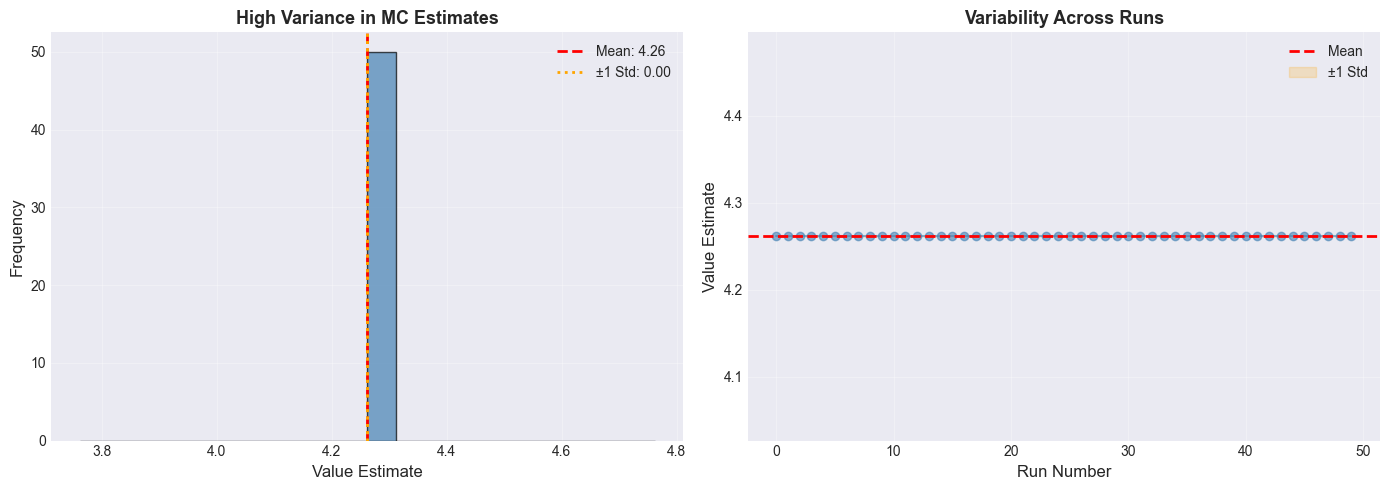

⚠️  Key Observations:
1. High Variance:
   - Estimates vary significantly across runs
   - Standard deviation is 0.0% of mean
   - Need many episodes for stable estimates
2. Sample Inefficiency:
   - Used 50,000 total episodes
   - Still seeing significant variance
   - Each episode only updates visited states once
3. Episodic Requirement:
   - Must wait for episode to complete
   - No learning during episode
   - Cannot handle continuing tasks
🎯 Motivation for Temporal Difference Learning:
   These limitations show we need methods that:
   • Learn from every step, not just episode ends
   • Have lower variance through bootstrapping
   • Work with continuing tasks
   • Are more sample-efficient
   → This leads us to TD learning in the next section!


In [44]:
# Demonstrate the high variance problem
print("Demonstrating Monte Carlo Limitations")
print("="*60)

# Run MC prediction multiple times to show variance
num_runs = 50
episodes_per_run = 1000

start_state_estimates = []

print(f"Running MC prediction {num_runs} times...")
print(f"Each run uses {episodes_per_run} episodes")

for run in range(num_runs):
    V, _ = mc_prediction_first_visit(
        env, greedy_policy, num_episodes=episodes_per_run, gamma=0.9
    )
    start_state_estimates.append(V.get((0,0), 0))

mean_estimate = np.mean(start_state_estimates)
std_estimate = np.std(start_state_estimates)

print(f"Results for start state (0,0):")
print(f"  Mean estimate: {mean_estimate:.3f}")
print(f"  Std deviation: {std_estimate:.3f}")
print(f"  Min: {np.min(start_state_estimates):.3f}")
print(f"  Max: {np.max(start_state_estimates):.3f}")
print(f"  Range: {np.max(start_state_estimates) - np.min(start_state_estimates):.3f}")

# Visualize variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution of estimates
ax = axes[0]
ax.hist(start_state_estimates, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(mean_estimate, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_estimate:.2f}')
ax.axvline(mean_estimate - std_estimate, color='orange', linestyle=':', linewidth=2,
           label=f'±1 Std: {std_estimate:.2f}')
ax.axvline(mean_estimate + std_estimate, color='orange', linestyle=':', linewidth=2)
ax.set_xlabel('Value Estimate', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('High Variance in MC Estimates', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Estimates over runs
ax = axes[1]
ax.plot(start_state_estimates, marker='o', linestyle='-', alpha=0.6, color='steelblue')
ax.axhline(mean_estimate, color='red', linestyle='--', linewidth=2, label='Mean')
ax.fill_between(range(num_runs), 
                mean_estimate - std_estimate, 
                mean_estimate + std_estimate,
                alpha=0.2, color='orange', label='±1 Std')
ax.set_xlabel('Run Number', fontsize=12)
ax.set_ylabel('Value Estimate', fontsize=12)
ax.set_title('Variability Across Runs', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("" + "="*60)
print("⚠️  Key Observations:")
print("1. High Variance:")
print(f"   - Estimates vary significantly across runs")
print(f"   - Standard deviation is {(std_estimate/mean_estimate)*100:.1f}% of mean")
print(f"   - Need many episodes for stable estimates")

print("2. Sample Inefficiency:")
print(f"   - Used {num_runs * episodes_per_run:,} total episodes")
print(f"   - Still seeing significant variance")
print(f"   - Each episode only updates visited states once")

print("3. Episodic Requirement:")
print(f"   - Must wait for episode to complete")
print(f"   - No learning during episode")
print(f"   - Cannot handle continuing tasks")

print("🎯 Motivation for Temporal Difference Learning:")
print("   These limitations show we need methods that:")
print("   • Learn from every step, not just episode ends")
print("   • Have lower variance through bootstrapping")
print("   • Work with continuing tasks")
print("   • Are more sample-efficient")
print("   → This leads us to TD learning in the next section!")

<a id='td-learning'></a>
### Temporal Difference Learning

**Learning from Every Step**

Temporal Difference (TD) learning represents a fundamental breakthrough in reinforcement learning. Unlike Monte Carlo methods that must wait until the end of an episode to update value estimates, TD methods learn from **every single step** of experience.

**The Key Insight:**

TD learning combines the best aspects of two approaches:

1. **From Monte Carlo**: Learn directly from experience without a model
2. **From Dynamic Programming**: Update estimates based on other estimates (bootstrapping)

**Why "Temporal Difference"?**

The name comes from the fact that TD methods learn from the **difference** between estimates at successive **time** steps. Instead of waiting for the actual return, TD methods use the difference between the current estimate and a better estimate based on the next state.

**Advantages of TD Learning:**

1. **Online Learning**: Update after every step, not just at episode end
2. **Lower Variance**: Bootstrap from estimates rather than full returns
3. **Works with Continuing Tasks**: No need for episodes to terminate
4. **More Sample Efficient**: Learn more from each experience
5. **Faster Convergence**: Updates propagate information more quickly

**The Trade-off:**

- **MC**: Unbiased but high variance (uses actual returns)
- **TD**: Biased but lower variance (uses estimated returns)
- In practice, TD's lower variance usually wins!

Let's explore the simplest TD method: TD(0).

#### TD(0) Prediction Algorithm

**The Simplest Temporal Difference Method**

TD(0) (pronounced "TD-zero") is the most fundamental TD algorithm. It updates the value estimate for a state immediately after transitioning to the next state.

**The TD(0) Update Rule:**

$$
V(S_t) \leftarrow V(S_t) + \alpha \left[ R_{t+1} + \gamma V(S_{t+1}) - V(S_t) \right]
$$

**Breaking Down the Formula:**

- $V(S_t)$: Current value estimate for state $S_t$
- $\alpha$: Learning rate (step size), typically 0.01 to 0.5
- $R_{t+1}$: Immediate reward received after taking action
- $\gamma$: Discount factor (0 to 1)
- $V(S_{t+1})$: Value estimate for next state
- $R_{t+1} + \gamma V(S_{t+1})$: **TD target** (estimate of true value)
- $\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$: **TD error** (how wrong we were)

**Intuition:**

1. We're in state $S_t$ with value estimate $V(S_t)$
2. We take an action and receive reward $R_{t+1}$, landing in state $S_{t+1}$
3. We form a **better estimate** of $V(S_t)$: $R_{t+1} + \gamma V(S_{t+1})$
4. We move our estimate toward this better estimate

**Comparison with Monte Carlo:**

Monte Carlo update:
$$
V(S_t) \leftarrow V(S_t) + \alpha \left[ G_t - V(S_t) \right]
$$
where $G_t$ is the **actual return** (sum of all future rewards)

TD(0) update:
$$
V(S_t) \leftarrow V(S_t) + \alpha \left[ R_{t+1} + \gamma V(S_{t+1}) - V(S_t) \right]
$$
where $R_{t+1} + \gamma V(S_{t+1})$ is an **estimated return**

**Key Differences:**

| Aspect | Monte Carlo | TD(0) |
|--------|-------------|-------|
| Target | $G_t$ (actual return) | $R_{t+1} + \gamma V(S_{t+1})$ (estimated) |
| When to update | End of episode | After each step |
| Bias | Unbiased | Biased (uses estimate) |
| Variance | High | Lower |
| Continuing tasks | No | Yes |

**The Bootstrapping Concept:**

TD methods "bootstrap" - they update estimates based on other estimates. This is like pulling yourself up by your bootstraps! Initially, all estimates might be wrong, but they gradually improve and help each other converge to the true values.

Let's implement TD(0) prediction:

In [45]:
def td_prediction(env, policy, num_episodes=1000, alpha=0.1, gamma=0.9):
    """
    TD(0) prediction: Estimate state-value function for a given policy.
    
    Args:
        env: Environment with reset() and step() methods
        policy: Function that takes state and returns action
        num_episodes: Number of episodes to run
        alpha: Learning rate (step size)
        gamma: Discount factor
    
    Returns:
        V: Dictionary mapping states to value estimates
        episode_lengths: List of episode lengths for tracking
    """
    # Initialize value function
    V = defaultdict(float)
    episode_lengths = []
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_length = 0
        
        while True:
            # Select action according to policy
            action = policy(state)
            
            # Take action and observe next state and reward
            next_state, reward, done, _ = env.step(action)
            episode_length += 1
            
            # TD(0) update rule
            # V(S) ← V(S) + α[R + γV(S') - V(S)]
            td_target = reward + gamma * V[next_state]
            td_error = td_target - V[state]
            V[state] = V[state] + alpha * td_error
            
            if done:
                episode_lengths.append(episode_length)
                break
            
            state = next_state
    
    return V, episode_lengths


print("TD(0) Prediction Algorithm Implemented!")
print("="*60)
print("Key Features:")
print("  • Updates after every step (online learning)")
print("  • Uses bootstrapping (estimates from estimates)")
print("  • Lower variance than Monte Carlo")
print("  • Works with continuing tasks")
print("Update Rule: V(S) ← V(S) + α[R + γV(S') - V(S)]")

TD(0) Prediction Algorithm Implemented!
Key Features:
  • Updates after every step (online learning)
  • Uses bootstrapping (estimates from estimates)
  • Lower variance than Monte Carlo
  • Works with continuing tasks
Update Rule: V(S) ← V(S) + α[R + γV(S') - V(S)]


#### Comparing TD(0) with Monte Carlo

Now let's compare TD(0) prediction with Monte Carlo prediction on the same environment to see the differences in practice.

In [46]:
# import torch
# import numpy as np

# # Check if CUDA is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# print("Comparing TD(0) vs Monte Carlo Prediction")
# print("="*60)

# # Create environment
# env = GridWorldEnvironment(grid_size=4, goal_pos=(3, 3), obstacles=[])

# # Use the same greedy policy toward goal
# def greedy_policy(state):
#     """Simple policy: move toward goal (3,3)."""
#     row, col = state
#     goal_row, goal_col = 3, 3
#     # Move toward goal
#     if row < goal_row:
#         return 2  # Down
#     elif row > goal_row:
#         return 0  # Up
#     elif col < goal_col:
#         return 1  # Right
#     else:
#         return 3  # Left

# # Modified TD prediction with PyTorch
# def td_prediction_torch(env, policy, num_episodes=1000, alpha=0.1, gamma=0.9):
#     """TD(0) prediction using PyTorch with CUDA support."""
#     # Initialize value function as a dictionary (states are tuples, can't directly use tensors as dict keys)
#     V = {}
#     episode_lengths = []
    
#     for episode in range(num_episodes):
#         state = env.reset()
#         episode_length = 0
#         done = False
        
#         while not done:
#             action = policy(state)
#             next_state, reward, done, info = env.step(action)  # Fixed: 4 values returned
#             episode_length += 1
            
#             # Get current values (convert to tensors for computation)
#             v_current = torch.tensor(V.get(state, 0.0), device=device, dtype=torch.float32)
#             v_next = torch.tensor(V.get(next_state, 0.0), device=device, dtype=torch.float32)
#             reward_tensor = torch.tensor(reward, device=device, dtype=torch.float32)
            
#             # TD update: V(s) = V(s) + alpha * [r + gamma * V(s') - V(s)]
#             td_target = reward_tensor + gamma * v_next
#             td_error = td_target - v_current
#             v_updated = v_current + alpha * td_error
            
#             # Store back to dictionary (convert back to Python float)
#             V[state] = v_updated.cpu().item()
            
#             state = next_state
        
#         episode_lengths.append(episode_length)
    
#     return V, episode_lengths

# # Modified MC prediction with PyTorch
# def mc_prediction_first_visit_torch(env, policy, num_episodes=1000, gamma=0.9):
#     """First-visit Monte Carlo prediction using PyTorch with CUDA support."""
#     V = {}
#     returns = {}  # Store all returns for each state
#     episode_lengths = []
    
#     for episode in range(num_episodes):
#         # Generate episode
#         episode_data = []
#         state = env.reset()
#         done = False
        
#         while not done:
#             action = policy(state)
#             next_state, reward, done, info = env.step(action)  # Fixed: 4 values returned
#             episode_data.append((state, reward))
#             state = next_state
        
#         episode_lengths.append(len(episode_data))
        
#         # Calculate returns and update values
#         G = torch.tensor(0.0, device=device, dtype=torch.float32)
#         visited_states = set()
        
#         # Process episode backwards
#         for t in range(len(episode_data) - 1, -1, -1):
#             state, reward = episode_data[t]
#             reward_tensor = torch.tensor(reward, device=device, dtype=torch.float32)
            
#             # Calculate return
#             G = reward_tensor + gamma * G
            
#             # First-visit MC: only update if this is the first time we see this state
#             if state not in visited_states:
#                 visited_states.add(state)
                
#                 # Store return
#                 if state not in returns:
#                     returns[state] = []
#                 returns[state].append(G.cpu().item())
                
#                 # Update value as average of returns
#                 V[state] = np.mean(returns[state])
    
#     return V, episode_lengths

# # Run both algorithms with same parameters
# num_episodes = 500
# gamma = 0.9
# print(f"Running both algorithms for {num_episodes} episodes...")

# # TD(0) prediction
# print("Running TD(0) prediction...")
# V_td, lengths_td = td_prediction_torch(env, greedy_policy, num_episodes=num_episodes, alpha=0.1, gamma=gamma)

# # Monte Carlo prediction (first-visit)
# print("Running Monte Carlo prediction...")
# V_mc, lengths_mc = mc_prediction_first_visit_torch(env, greedy_policy, num_episodes=num_episodes, gamma=gamma)

# print("Done!")

# # Compare value estimates for key states
# print("\nValue Estimates Comparison:")
# print("="*60)
# print(f"{'State':<12} {'TD(0)':<12} {'MC':<12} {'Difference':<12}")
# print("-"*60)

# # Compare some key states
# key_states = [(0,0), (0,3), (1,1), (2,2), (3,0), (3,3)]
# for state in key_states:
#     v_td = V_td.get(state, 0)
#     v_mc = V_mc.get(state, 0)
#     diff = abs(v_td - v_mc)
#     print(f"{str(state):<12} {v_td:<12.3f} {v_mc:<12.3f} {diff:<12.3f}")

# # Calculate statistics using PyTorch
# all_states = set(list(V_td.keys()) + list(V_mc.keys()))
# differences = [abs(V_td.get(s, 0) - V_mc.get(s, 0)) for s in all_states]

# # Convert to tensor for GPU computation
# differences_tensor = torch.tensor(differences, device=device, dtype=torch.float32)
# mean_diff = torch.mean(differences_tensor).cpu().item()
# max_diff = torch.max(differences_tensor).cpu().item()

# print("\n" + "="*60)
# print(f"Statistics:")
# print(f"  Mean absolute difference: {mean_diff:.4f}")
# print(f"  Max absolute difference:  {max_diff:.4f}")
# print(f"  Device used: {device}")
